In [34]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import transforms
import torchvision.datasets as datasets

from modules import Trainer
from modules.models import LeNet_5, LeNet_5_filocl

## Load MNIST


In [35]:
# Load MNIST 
trainset = datasets.MNIST(
    root='./data',
    train=True,
    download=True, 
    transform=transforms.Compose([transforms.ToTensor(),transforms.Pad(2)])
)

testset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(),transforms.Pad(2)])
)

In [36]:
# ATTENTION: the validation set comes from the train set,
# not from the test set!
trainset, valset = torch.utils.data.random_split(
    trainset, 
    [int(0.8 * len(trainset)), int(0.2 * len(trainset))]
)

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True,
    num_workers=4
)

val_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=len(valset)//4,
    shuffle=False,
    num_workers=4,
)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=len(testset)//4,
    shuffle=False,
    num_workers=4,
)

print("Training dataset size: ", len(trainset))
print("Validation dataset size: ", len(valset))
print("Testing dataset size: ", len(testset))

Training dataset size:  48000
Validation dataset size:  12000
Testing dataset size:  10000


In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using: {device}')

Using: cuda


## Filter creation

In [74]:
# Filter creation 
def create_filters(filter_size, stripe_width):
    filters = []

    start = (filter_size - stripe_width) //2     

    # Horizontal
    horizontal = torch.zeros((filter_size, filter_size), dtype=torch.float32)
    horizontal[start:start+stripe_width, :] = 1  # Set horizontal stripes with ones
    filters.append(horizontal)  

    # Vertical
    vertical = torch.zeros((filter_size,filter_size), dtype=torch.float32)
    vertical[:, start:start+stripe_width] = 1  
    filters.append(vertical)
    
    # Diagonal 45deg & 135deg
    diag45 = torch.zeros((filter_size,filter_size), dtype=torch.float32)
    diag135 = torch.zeros((filter_size,filter_size), dtype=torch.float32)

    for i in range(filter_size):
        for j in range(stripe_width):
            if 0 <= i+j < filter_size:
                diag45[i, i+j] = 1
              
            if 0 <= filter_size-i-1-j < filter_size:
                diag135[i, filter_size-i-1-j] = 1

    filters.append(diag45)
    filters.append(diag135)

    return filters

Models and training

In [61]:
# Vanilla lenet
vanilla_model = LeNet_5().to(device)

# Filtered lenet: create the filters and istantiate the network
filter_size = 7
stripe_width = 3

filters = create_filters(filter_size,stripe_width)
filters = torch.stack(filters).unsqueeze(1).to(device)

filtered_model = LeNet_5_filocl(filters=filters, stripe_width=stripe_width).to(device)


# Optimizer and rest is the same
optimizer_type = torch.optim.Adam 
loss_fn = torch.nn.CrossEntropyLoss()
start_lr = 1e-3 
epochs = 10


for model in [filtered_model, vanilla_model]:

    # Check if the statedict already exists
    if Path(f'statedicts/{model}.pth').is_file():
        print(f'{model}: statedict already present. Loading.')
        model.load_state_dict(
            torch.load(f"statedicts/{model}.pth",
            map_location=device)
        )
        continue

    optimizer = optimizer_type(model.parameters(), lr=start_lr)
    trainer = Trainer(model)

    print(f'Training {model}')

    trainer.train(
        trainloader = train_loader,
        validloader = val_loader,
        optimizer = optimizer,
        loss_fn = loss_fn,
        epochs = epochs,
        plotting = True,
    )

    torch.save(model.state_dict(),f"statedicts/{model}.pth") 


LeNet_5_w7_sw3: statedict already present. Loading.
LeNet_5_vanilla: statedict already present. Loading.


## Occlusions

In [ ]:
def occlusion_transform(stripe_width, stripe_spacing):

    def f(image):

        # Very cool implementation obtained with the help of perplexity.ai
        # It can be tweaked to obtain any occlusion angle (also in filters!)
        i = torch.arange(len(image[0]))
        j = i

        # This is an "external" sum (notice the transpositions)   
        diagonals = (i[:, None] - 1*j[None, :]).abs()/1

        period = stripe_width+stripe_spacing
        mask = (diagonals % period) < stripe_width

        image[0,mask] = 0

        return image

    return f

Results exist. Loading.
Results exist. Loading.


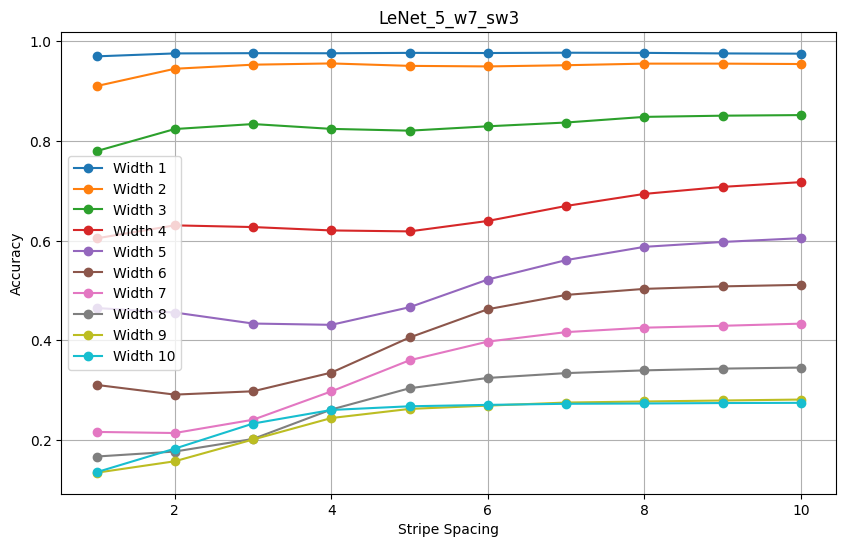

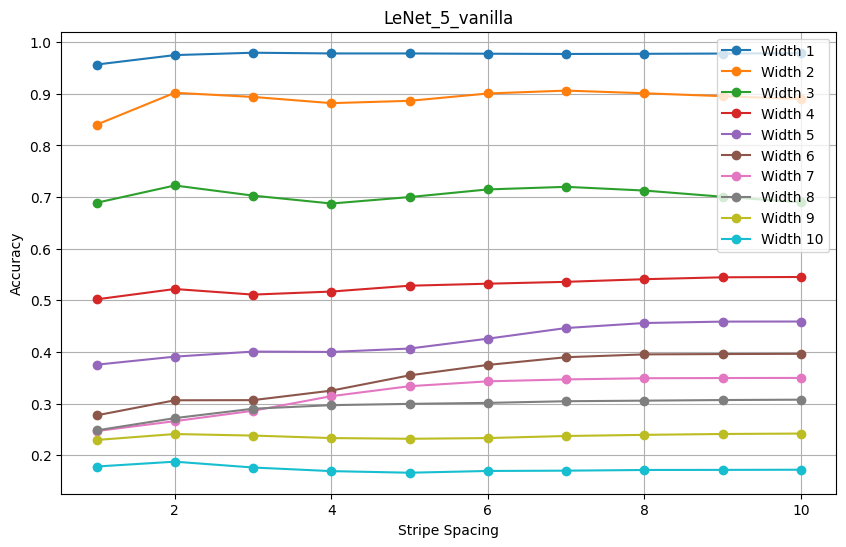

In [64]:
# Generate occlusion configurations dynamically: (width, spacing) from 1 to 10
occlusion_configs = [(w, s) for w in range(1, 11) for s in range(1, 11)]

for model in [filtered_model, vanilla_model]:

    if Path(f'results/{model}.npy').is_file():
        print('Results exist. Loading.')
        results = np.load(f'results/{model}.npy')

    else:
        results = []

        for stripe_width, stripe_spacing in tqdm(occlusion_configs):

            testset = datasets.MNIST(
                root='./data',
                train=False,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Pad(2),
                    occlusion_transform(stripe_width, stripe_spacing)
                ])
            )

            test_loader = torch.utils.data.DataLoader(
                testset, 
                batch_size=len(testset)//4,
                shuffle=False,
                num_workers=4,
            )

            # Test accuracy
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    predictions = torch.argmax(outputs, dim=1)
                    correct += (predictions == labels).sum().item()
                    total += labels.size(0)
            
            accuracy = correct / total
            results.append((stripe_width, stripe_spacing, accuracy))

        results = np.array(results)
        np.save(f'results/{model}.npy', results)

    # Get unique widths
    widths = np.unique(results[:, 0])

    # Plot accuracy vs. spacing for different widths
    plt.figure(figsize=(10, 6))

    for width in widths:
        subset = results[results[:, 0] == width]  # Get data for this width
        plt.plot(subset[:, 1], subset[:, 2], marker='o', linestyle='-', label=f'Width {int(width)}')

    plt.xlabel('Stripe Spacing')
    plt.ylabel('Accuracy')
    plt.title(f'{model}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'figures/{model}.png', dpi=300)

    # print(f"Occlusion (Width={stripe_width}, Spacing={stripe_spacing}) -> Accuracy: {accuracy:.4f}")

#print("All datasets have been saved.")

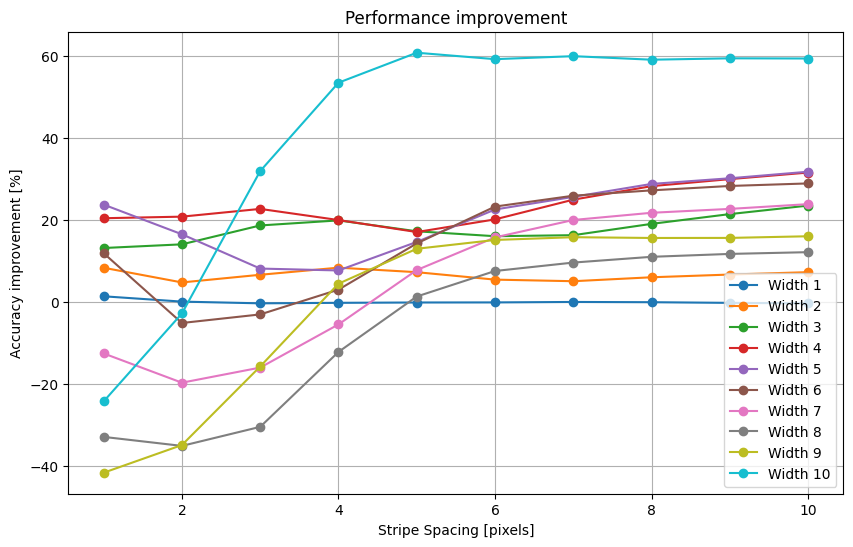

In [68]:
filtered_accs = np.load(f'results/{filtered_model}.npy')
vanilla_accs = np.load(f'results/{vanilla_model}.npy')

diff_accs = filtered_accs
diff_accs[:,2] = (filtered_accs[:,2]/vanilla_accs[:,2] - 1) * 100

widths = np.unique(diff_accs[:, 0])

# Plot accuracy vs. spacing for different widths
plt.figure(figsize=(10, 6))

for width in widths:
    subset = diff_accs[diff_accs[:, 0] == width]  # Get data for this width
    plt.plot(subset[:, 1], subset[:, 2], marker='o', linestyle='-', label=f'Width {int(width)}')

plt.xlabel('Stripe Spacing [pixels]')
plt.ylabel('Accuracy improvement [%]')
plt.title(f'Performance improvement')
plt.legend()
plt.grid(True)
